In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.ndimage as spn 


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, permutation_test_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from joblib import Parallel, delayed

In [4]:
lab_desktop = True
if lab_desktop : 
    data_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
    result_path = '/home/INT/mifsud.l/Bureau/pattern_classification_git/results/'
else : 
    data_path = '/home/laurie/Bureau/pattern_classification_git/results/' 
    result_path = '/home/laurie/Bureau/pattern_classification_git/results/'

In [5]:
target = pd.read_csv(data_path + 'target.csv')

event_labels = np.load(data_path + 'event_labels.npy')
event_vector = np.load(data_path + 'event_vector.npy')

spike_convolved = np.load(data_path +  'spike_convolved.npy')
spike_convolved_shuff = np.load(data_path + 'spike_convol_shuff.npy')

synchrony = np.load(data_path +  'synchrony.npy')
synchrony_shuff = np.load(data_path + 'synchrony_shuff.npy')

n_trials, n_times, n_neurons = spike_convolved.shape
n_pairs = synchrony.shape[2]

In [6]:
# Build pipeline
n_splits = 10
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
# Standardisation scheme
scaler = StandardScaler()
# Algo
#estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
#estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10)
#clf = make_pipeline(scaler, estimator)

#clf = LinearDiscriminantAnalysis()

clf = make_pipeline(scaler, SVC())

n_permutations = 10

def classify_2D(X, y):
    if np.isnan(X).any() : 
        return np.nan, np.array([np.nan]*n_permutations)
    else : 
        score, perm_score, pval = permutation_test_score(clf, X, y, cv=cvs0, n_jobs=1, n_permutations=n_permutations, random_state=20)
        return score, perm_score


def classify_3D(X, y):
    n_times = X.shape[1]
    out = Parallel(n_jobs=-1)(delayed(classify_2D)(X[:,t,:], y) for t in range(n_times))
    da, perm = zip(*out)
    da = np.array(da)
    perm = np.array(perm)
    return da, perm  

# Classify firing rate

In [7]:
result_fr = {}
var = spike_convolved
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(var[idx,:,:], target.loc[idx,'position'].values)
    result_fr[t] = [da, perm]


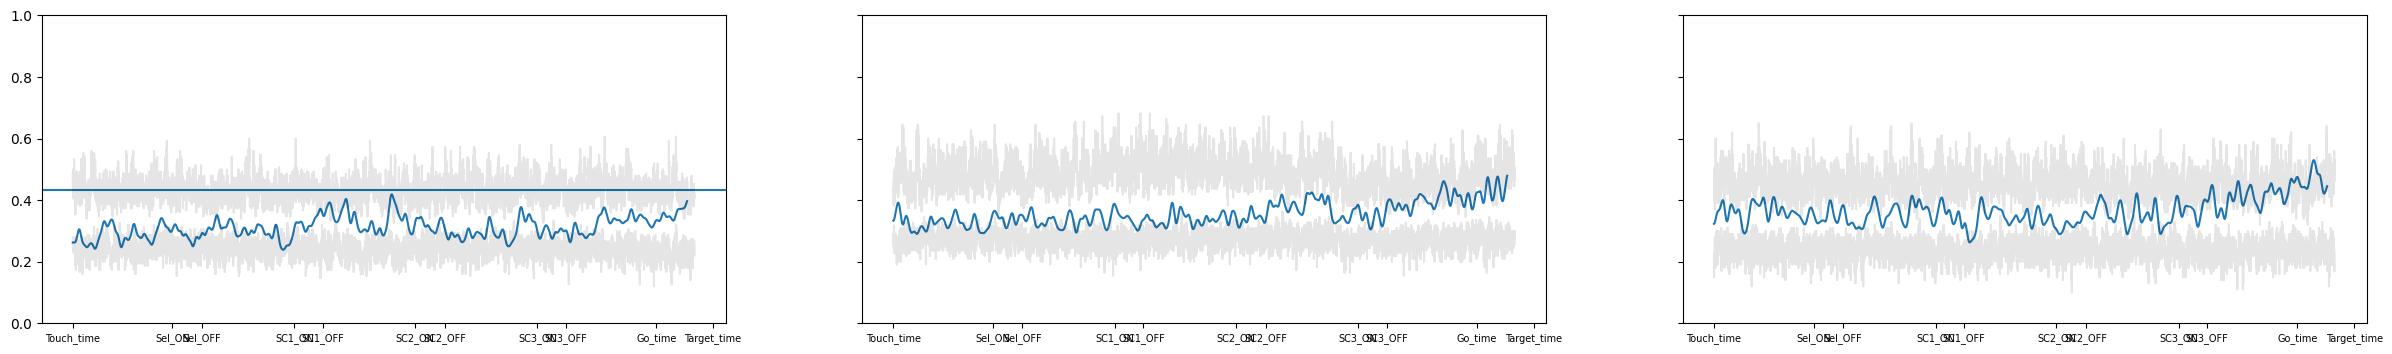

In [9]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)


plt.sca(axs[0])
#plt.plot(result[1][0])
plt.plot(spn.gaussian_filter1d(result_fr[1][0], 20))
p_min = result_fr[1][1].min(axis=1)
p_max = result_fr[1][1].max(axis=1)
p_per = np.nanpercentile(result_fr[1][1].ravel(), 95)
plt.axhline(p_per)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7)
plt.ylim(0,1.0);



plt.sca(axs[1])
#plt.plot(result_fr[2][0])
plt.plot(spn.gaussian_filter1d(result_fr[2][0], 20))
p_min = result_fr[2][1].min(axis=1)
p_max = result_fr[2][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
#plt.plot(result_fr[3][0])
plt.plot(spn.gaussian_filter1d(result_fr[3][0], 20))
p_min = result_fr[3][1].min(axis=1)
p_max = result_fr[3][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)
plt.xticks(event_vector, event_labels, fontsize=7);

# Classify shuffled_firing rate

In [10]:
result_fr_shuff = {}
var = spike_convolved_shuff
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(var[idx,:,:], target.loc[idx,'position'].values)
    result_fr_shuff[t] = [da, perm]


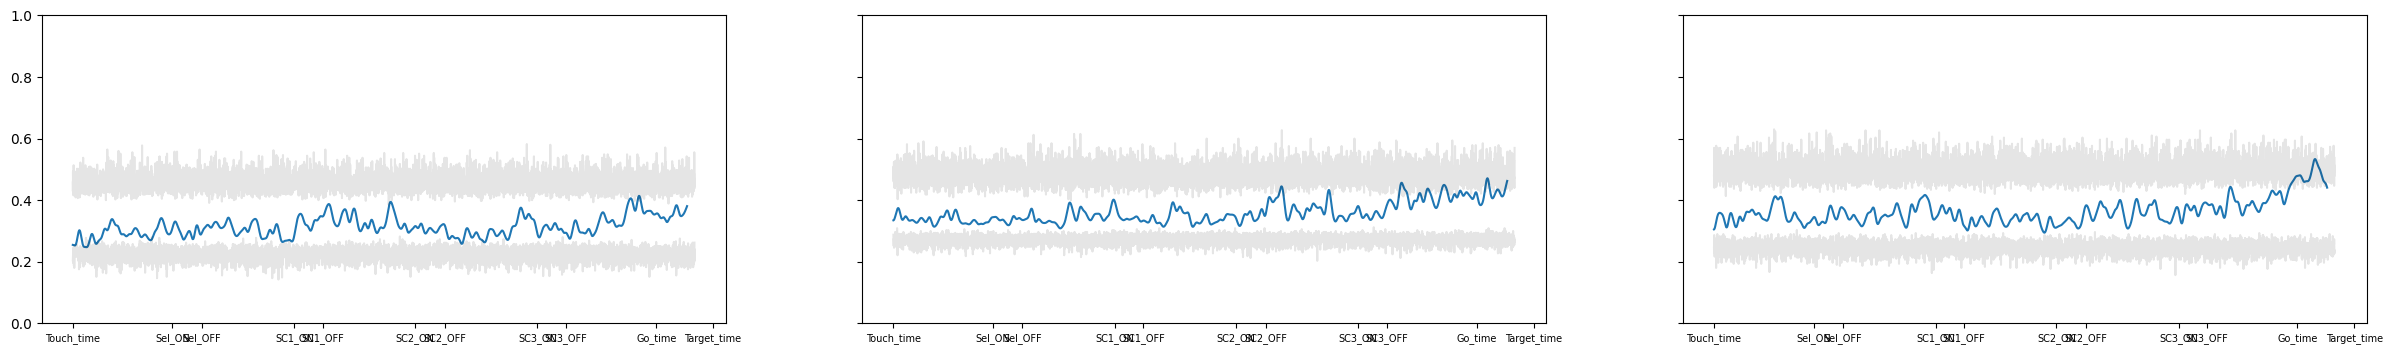

In [14]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)


plt.sca(axs[0])
#plt.plot(result[1][0])
plt.plot(spn.gaussian_filter1d(result_fr_shuff[1][0], 20))
p_min = result_fr_shuff[1][1].min(axis=1)
p_max = result_fr_shuff[1][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7)
plt.ylim(0,1.0);



plt.sca(axs[1])
#plt.plot(result_fr_shuff[2][0])
plt.plot(spn.gaussian_filter1d(result_fr_shuff[2][0], 20))
p_min = result_fr_shuff[2][1].min(axis=1)
p_max = result_fr_shuff[2][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
#plt.plot(result_fr_shuff[3][0])
plt.plot(spn.gaussian_filter1d(result_fr_shuff[3][0], 20))
p_min = result_fr_shuff[3][1].min(axis=1)
p_max = result_fr_shuff[3][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)
plt.xticks(event_vector, event_labels, fontsize=7);

# Classify synchrony

In [16]:
result_synch = {}
var = synchrony
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(var[idx,:,:], target.loc[idx,'position'].values)
    result_synch[t] = [da, perm]


KeyboardInterrupt: 

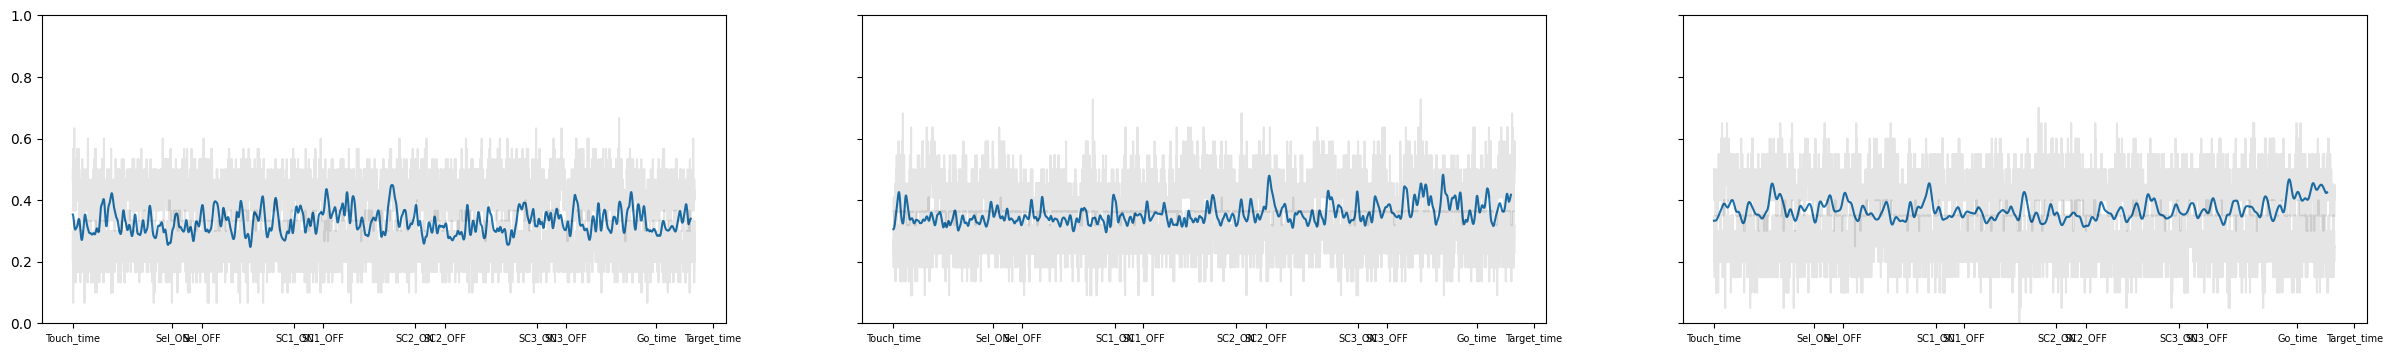

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)


plt.sca(axs[0])
#plt.plot(result_synch[1][0])
plt.plot(spn.gaussian_filter1d(result_synch[1][0], 10))
p_min = result_synch[1][1].min(axis=1)
p_max = result_synch[1][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7)
plt.ylim(0,1.0);



plt.sca(axs[1])
#plt.plot(result_synch[2][0])
plt.plot(spn.gaussian_filter1d(result_synch[2][0], 10))
p_min = result_synch[2][1].min(axis=1)
p_max = result_synch[2][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
#plt.plot(result_synch[3][0])
plt.plot(spn.gaussian_filter1d(result_synch[3][0], 20))
p_min = result_synch[3][1].min(axis=1)
p_max = result_synch[3][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)
plt.xticks(event_vector, event_labels, fontsize=7);

# Classify shuffled synchrony

In [ ]:
result_synch_shuff = {}
var = synchrony_shuff
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(var[idx,:,:], target.loc[idx,'position'].values)
    result_synch_shuff[t] = [da, perm]


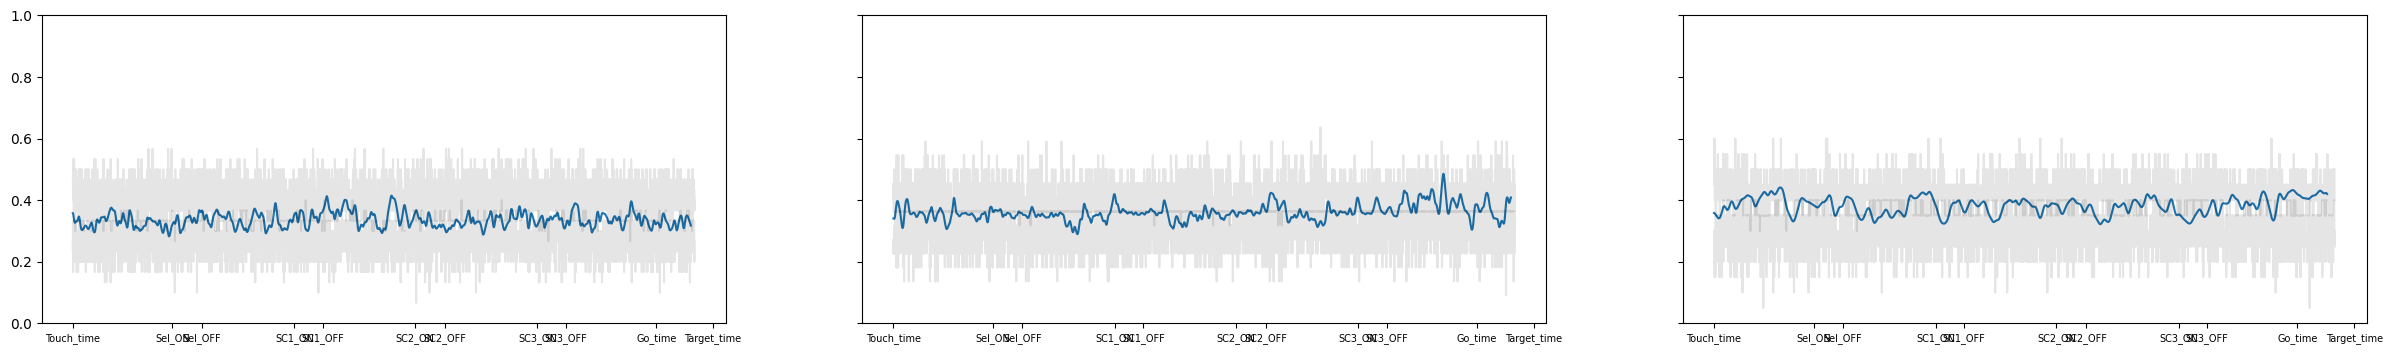

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)


plt.sca(axs[0])
#plt.plot(result_synch_shuff[1][0])
plt.plot(spn.gaussian_filter1d(result_synch_shuff[1][0], 10))
p_min = result_synch_shuff[1][1].min(axis=1)
p_max = result_synch_shuff[1][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7)
plt.ylim(0,1.0);



plt.sca(axs[1])
#plt.plot(result_synch_shuff[2][0])
plt.plot(spn.gaussian_filter1d(result_synch_shuff[2][0], 10))
p_min = result_synch_shuff[2][1].min(axis=1)
p_max = result_synch_shuff[2][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)

plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
#plt.plot(result_synch_shuff[3][0])
plt.plot(spn.gaussian_filter1d(result_synch_shuff[3][0], 20))
p_min = result_synch_shuff[3][1].min(axis=1)
p_max = result_synch_shuff[3][1].max(axis=1)
plt.plot(p_min, color="k", alpha=0.1)
plt.plot(p_max, color="k",  alpha=0.1)
plt.xticks(event_vector, event_labels, fontsize=7);

In [ ]:
from ipywidgets import interact

@interact(label=["trial_type", "position"], x_variable=["fr", "fr_shuffled"])
def plot(label="trial_type)", x_variable="fr",):

    if x_variable == "fr":
        _x = spike_convolved
    elif x_variable == "fr_shuffled":
        _x = spike_convolved_shuff

    da, perm = classify_3D(_x, target[label].values)
    plt.plot(da)
    p_per = np.nanpercentile(perm.ravel(), 95)
    p_min = perm.min(axis=1)
    p_max = perm.max(axis=1)
    plt.fill_between(
        np.arange(0,perm.shape[0]),
        p_min,
        p_max,
        color='grey',
        alpha=1
    )
    plt.axhline(p_per)
    plt.ylim(0,1.0);
    plt.title(f"Decoding {label} using {x_variable}")

interactive(children=(Dropdown(description='label', options=('trial_type', 'position'), value='trial_type'), D…

In [ ]:
np.nanpercentile(perm, 95, axis=1).shape


In [ ]:
da_, perm_ = classify_3D(spike_convolved, target['trial_type'].values)
da, perm = classify_3D(spike_convolved_shuff, target['trial_type'].values)

In [ ]:
plt.plot(da, label='suffled fr')
plt.plot(da_, label='fr')
plt.legend()
plt.ylim(0,1.0);

In [ ]:
da, perm = classify_3D(spike_convolved, target['trial_type'].values)

In [ ]:
plt.plot(spike_convolved[0,:,0])

In [ ]:
perm.shape

In [ ]:
da.shape

In [ ]:
np.nanpercentile(perm,99)

In [ ]:
plt.plot(da)
plt.axhline(np.nanpercentile(perm,99))
plt.ylim(0,1.0);

In [ ]:
def classify_3D(X, y):
    n_times = X.shape[1]
    out = Parallel(n_jobs=-1)(delayed(classify_2D)(X[:,t:t+100,:].mean(axis=1), y) for t in np.arange(0,n_times, 100))
    da, perm = zip(*out)
    da = np.array(da)
    return da, np.nanpercentile(np.concatenate(perm), 99)
    # return da, np.nanmax(np.concatenate(perm))

result = {}
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(spike_convolved[idx,:,:], target.loc[idx,'position'].values)
    result[t] = [da, perm]

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)

plt.sca(axs[0])
plt.plot(result[1][0])
plt.axhline(result[1][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[1])
plt.plot(result[2][0])
plt.axhline(result[2][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
plt.plot(result[3][0])
plt.axhline(result[3][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);

In [ ]:
def classify_3D(X, y):
    n_times = X.shape[1]
    out = Parallel(n_jobs=-1)(delayed(classify_2D)(X[:,t:t+200,:].mean(axis=1), y) for t in np.arange(0,n_times, 200))
    da, perm = zip(*out)
    da = np.array(da)
    #return da, np.nanpercentile(np.concatenate(perm), 99)
    return da, np.nanmean(np.concatenate(perm))

result = {}
for t, idx, in target.groupby('trial_type').groups.items():
    idx = idx.values
    da, perm = classify_3D(spike_convolved[idx,:,:], target.loc[idx,'position'].values)
    result[t] = [da, perm]


In [ ]:
fig, axs = plt.subplots(1,3, figsize=(30,4), sharex=True, sharey=True)

plt.sca(axs[0])
plt.plot(result[1][0])
plt.axhline(result[1][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[1])
plt.plot(result[2][0])
plt.axhline(result[2][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);



plt.sca(axs[2])
plt.plot(result[3][0])
plt.axhline(result[3][1], color="k")
#plt.xticks(event_vector, event_labels, fontsize=7);